In [1]:
#import libraries required for analysis
from change_detection import functions as chg
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
from lib.outliers import *  #This is copied into the local folder from a branch ebmdatalab pandas library - it will be placed in its own repo to install at a later dat

In [2]:
opioids_class = chg.ChangeDetection('practice_data_opioid%',
                                    measure=True,
                                    direction='down',
                                    overwrite=False,
                                    verbose=False,
                                    draw_figures='no')
opioids_class.run()

Using cached data


In [3]:
opioids = opioids_class.concatenate_outputs()
opioids.head()

is.nbreak  is.tfirst  is.tfirst.pknown  \
measure                 name                                             
practice_data_opioidome A81001  0         NaN        NaN                 
                        A81002  0         NaN        NaN                 
                        A81004  0         NaN        NaN                 
                        A81005  0         NaN        NaN                 
                        A81006  1          inf        inf                

                                is.tfirst.pknown.offs  is.tfirst.offs  \
measure                 name                                            
practice_data_opioidome A81001 NaN                    NaN               
                        A81002 NaN                    NaN               
                        A81004 NaN                    NaN               
                        A81005 NaN                    NaN               
                        A81006  inf                    inf              

                                is.tfirst.big  is.slope.ma  is.slope.ma.prop  \
measure                 name                                                   
practice_data_opioidome A81001 NaN            NaN          NaN                 
                        A81002 NaN            NaN          NaN                 
                        A81004 NaN            NaN          NaN                 
                        A81005 NaN            NaN          NaN                 
                        A81006 NaN            NaN          NaN                 

                                is.slope.ma.prop.lev  is.intlev.initlev  \
measure                 name                                              
practice_data_opioidome A81001 NaN                   NaN                  
                        A81002 NaN                   NaN                  
                        A81004 NaN                   NaN                  
                        A81005 NaN                   NaN                  
                        A81006 NaN                   NaN                  

                                is.intlev.finallev  is.intlev.levd  \
measure                 name                                         
practice_data_opioidome A81001 NaN                 NaN               
                        A81002 NaN                 NaN               
                        A81004 NaN                 NaN               
                        A81005 NaN                 NaN               
                        A81006  50330.014139       NaN               

                                is.intlev.levdprop  
measure                 name                        
practice_data_opioidome A81001 NaN                  
                        A81002 NaN                  
                        A81004 NaN                  
                        A81005 NaN                  
                        A81006 NaN

### Get open practices list to filter out closed practices

In [4]:
query = """
SELECT
  DISTINCT code
FROM
  ebmdatalab.hscic.practices
WHERE
  status_code = "A"
"""
open_practices = bq.cached_read(query,csv_path='data/open_practices.csv')
open_practices.head()

,code
0,W94609
1,W94622
2,W95036
3,A99915
4,A99960


### Get practices with a small list size to filter them out 

In [5]:
query = """
SELECT
  DISTINCT practice
FROM
  ebmdatalab.hscic.practice_statistics
WHERE
  total_list_size < 2000
"""
small_list_size = bq.cached_read(query,csv_path='data/small_list_size.csv')
small_list_size.head()

,practice
0,Y00031
1,Y00613
2,Y02313
3,Y02797
4,Y02926


### Remove small list sizes and closed/dormant practices

In [6]:
print(len(opioids))
mask = opioids.index.get_level_values(1).isin(open_practices['code'])
opioids = opioids.loc[mask]
print(len(opioids))
mask = opioids.index.get_level_values(1).isin(small_list_size['practice'])
opioids = opioids.loc[~mask]
print(len(opioids))
opioids.head()

36856
33581
32484


is.nbreak  is.tfirst  is.tfirst.pknown  \
measure                 name                                             
practice_data_opioidome A81001  0         NaN        NaN                 
                        A81002  0         NaN        NaN                 
                        A81004  0         NaN        NaN                 
                        A81005  0         NaN        NaN                 
                        A81006  1          inf        inf                

                                is.tfirst.pknown.offs  is.tfirst.offs  \
measure                 name                                            
practice_data_opioidome A81001 NaN                    NaN               
                        A81002 NaN                    NaN               
                        A81004 NaN                    NaN               
                        A81005 NaN                    NaN               
                        A81006  inf                    inf              

                                is.tfirst.big  is.slope.ma  is.slope.ma.prop  \
measure                 name                                                   
practice_data_opioidome A81001 NaN            NaN          NaN                 
                        A81002 NaN            NaN          NaN                 
                        A81004 NaN            NaN          NaN                 
                        A81005 NaN            NaN          NaN                 
                        A81006 NaN            NaN          NaN                 

                                is.slope.ma.prop.lev  is.intlev.initlev  \
measure                 name                                              
practice_data_opioidome A81001 NaN                   NaN                  
                        A81002 NaN                   NaN                  
                        A81004 NaN                   NaN                  
                        A81005 NaN                   NaN                  
                        A81006 NaN                   NaN                  

                                is.intlev.finallev  is.intlev.levd  \
measure                 name                                         
practice_data_opioidome A81001 NaN                 NaN               
                        A81002 NaN                 NaN               
                        A81004 NaN                 NaN               
                        A81005 NaN                 NaN               
                        A81006  50330.014139       NaN               

                                is.intlev.levdprop  
measure                 name                        
practice_data_opioidome A81001 NaN                  
                        A81002 NaN                  
                        A81004 NaN                  
                        A81005 NaN                  
                        A81006 NaN

## Total OME

,is.tfirst.big,is.intlev.levdprop,plots
name,,,
P84019,44.0,0.736706,
Y01695,47.0,0.619678,
N81626,28.0,0.610835,
N81051,35.0,0.591525,
P87024,26.0,0.561731,
B85042,31.0,0.545953,
M85007,13.0,0.536242,
B87600,34.0,0.525459,
B86016,34.0,0.521498,

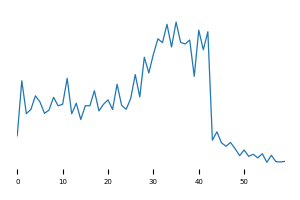
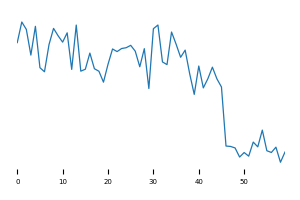
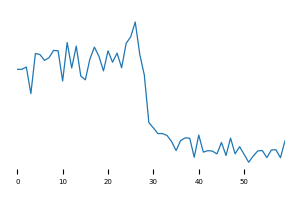
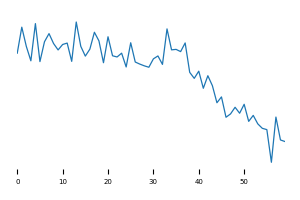
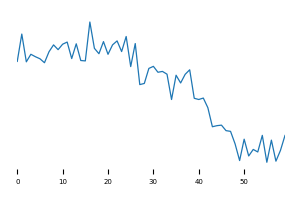
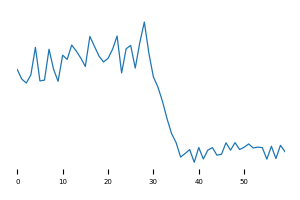
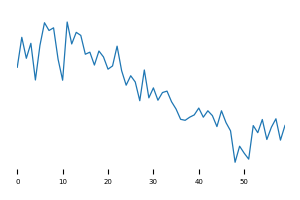
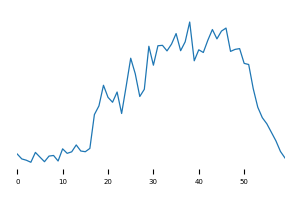
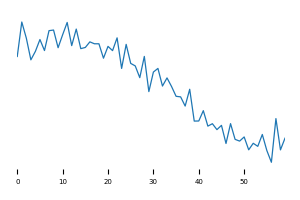
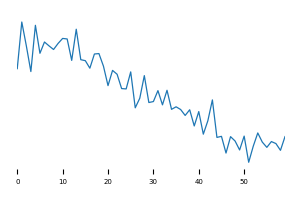

In [7]:
filtered_sparkline(opioids,
                   'practice_data_opioid/practice_data_opioidome',
                   'practice_data_opioidome')

In [8]:
practice_data_opioidome = opioids.loc["practice_data_opioidome"]

In [9]:
practice_data_opioidspercent = opioids.loc["practice_data_opioidspercent"]

In [10]:
practice_data_opioidper1000 = opioids.loc["practice_data_opioidper1000"]

In [11]:
practice_data_opioidome.index.nunique() #count of number of practices

6541

In [12]:
practice_data_opioidome = practice_data_opioidome.replace([np.inf, -np.inf], np.nan) #replace infinite values https://stackoverflow.com/questions/17477979/dropping-infinite-values-from-dataframes-in-pandas
practice_data_opioidome.head()

,is.nbreak,is.tfirst,is.tfirst.pknown,is.tfirst.pknown.offs,is.tfirst.offs,is.tfirst.big,is.slope.ma,is.slope.ma.prop,is.slope.ma.prop.lev,is.intlev.initlev,is.intlev.finallev,is.intlev.levd,is.intlev.levdprop
name,,,,,,,,,,,,,
A81001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A81002,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A81004,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A81005,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A81006,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50330.014139,NaN,NaN


In [13]:
decile_ome = pd.read_csv(r'data/practice_data_opioid/practice_data_opioidome/bq_cache.csv') ##why can't it find file if shortened url?
decile_ome['calc_value'] = decile_ome['numerator'] / decile_ome['denominator']
decile_ome['month'] = pd.to_datetime(decile_ome['month'])
decile_ome.head()

,month,code,numerator,denominator,calc_value
0,2017-10-01,A81001,207714.0,4.147,50087.774295
1,2019-10-01,A81001,202485.0,4.103,49350.475262
2,2018-10-01,A81001,220460.0,4.089,53915.382734
3,2018-08-01,A81001,243236.2,4.119,59052.245691
4,2015-06-01,A81001,210548.0,4.187,50286.123716


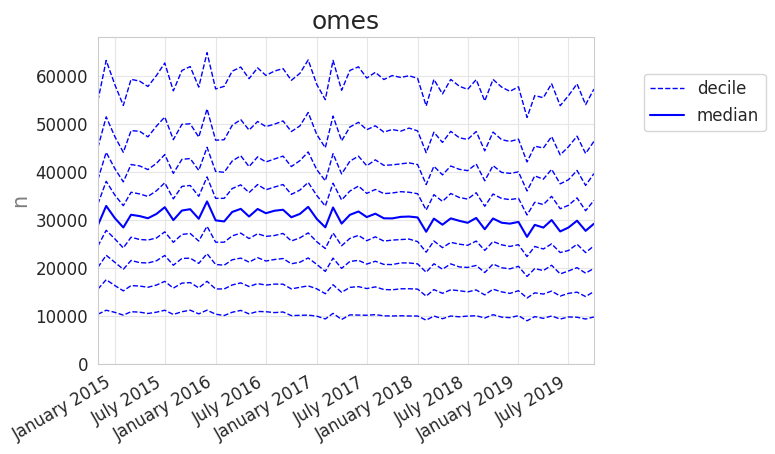

In [14]:
charts.deciles_chart(
        decile_ome,
        period_column='month',
        column='calc_value',
        title="omes",
        ylabel="n",
        show_outer_percentiles=False,
        show_legend=True
)
plt.show()

In [15]:
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns

In [16]:
offset_date = practice_data_opioidome['is.tfirst.big'] -1
offset_date = offset_date.dropna().apply(lambda x: relativedelta(months=x))
practice_breaks_ome = decile_ome['month'].min() + offset_date
#practice_breaks_cer.loc[practice_breaks_cer=='2013-03-01'] = practice_breaks_cer.loc[practice_breaks_cer=='2013-03-01'] + pd.DateOffset(days=1)
practice_breaks_ome.head()

name
A81007   2017-07-01
A81009   2015-08-01
A81012   2017-04-01
A81016   2015-08-01
A81018   2016-01-01
Name: is.tfirst.big, dtype: datetime64[ns]

In [17]:
mean_slope = practice_data_opioidome[['is.tfirst.big','is.slope.ma']]
mean_slope = mean_slope.groupby('is.tfirst.big').mean()
mean_slope = pd.concat([mean_slope,pd.DataFrame([[0]], columns=['is.slope.ma'])],axis=0)
mean_slope = mean_slope.sort_index()
mean_slope.head()#.plot.bar()

,is.slope.ma
0.0,0.000000
2.0,-252.234682
3.0,-1456.534127
4.0,-4929.445476
5.0,-774.377738


In [18]:
mean_change = practice_data_opioidome[['is.tfirst.big','is.intlev.levd']]
mean_change = mean_change.groupby('is.tfirst.big').mean()
mean_change = pd.concat([mean_change,pd.DataFrame([[0]], columns=['is.intlev.levd'])],axis=0)
mean_change = mean_change.sort_index()
mean_change.head()#.plot.bar()

,is.intlev.levd
0.0,0.000000
2.0,2372.609699
3.0,10892.229441
4.0,6920.727722
5.0,-839.356435


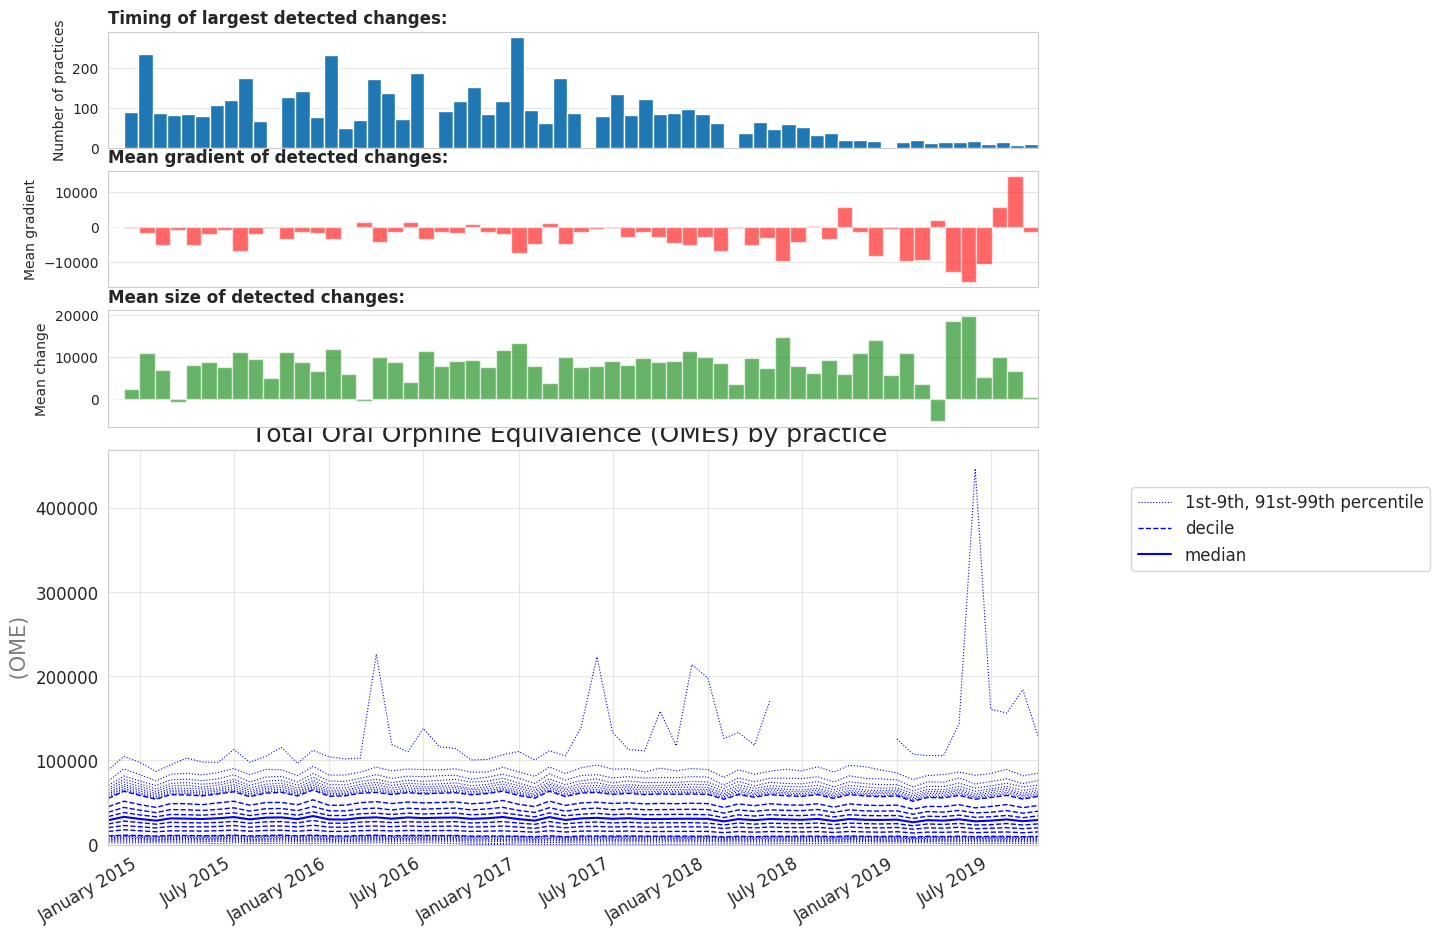

In [19]:
# Plot figure with subplots of different sizes
fig,ax = plt.subplots(1)
# set up subplot grid
gridspec.GridSpec(7,4)

# decile subplot

ax = plt.subplot2grid((7,4), (3,0), colspan=4, rowspan=3)
charts.deciles_chart(
        decile_ome,
        period_column='month',
        column='calc_value',
        title="Total Oral Orphine Equivalence (OMEs) by practice ",
        ylabel=" (OME) ",
        show_outer_percentiles=True,
        show_legend=True,
        ax=ax
)
#ax.set_title('Practice deciles and extreme percentiles:',loc='left',fontweight='bold')
#ax.set_ylabel('Proportion of Cerazette prescribing')
#ax.set_xlim([practice_deciles_cer.index.min(),practice_deciles_cer.index.max()])
#ax.set_xlabel('Year', fontsize = 11)
#ax.set_ylim([0,1])



#ax.axvline(x='2012-12-01',linewidth=1, color='k')
#ax.axvline(x='2013-07-01',linewidth=1, color='k')
#ax.annotate('Cerazette patent expired', ('2012-12-08',0.65),
 #           fontweight='bold',rotation=90,fontsize=14,color='#2a72a3',alpha=.9)
#ax.annotate('Price begins to drop', ('2013-07-08',0.53),
 #           fontweight='bold',rotation=90,fontsize=14,color='#2a72a3',alpha=.9)

# timing of change
ax = plt.subplot2grid((7,4), (0,0), colspan=4)
ax.set_title('Timing of largest detected changes:',loc='left',fontweight='bold')
ax.set_ylabel('Number of practices')
ax.axes.xaxis.set_ticklabels([])
ax.set_xlim([decile_ome['month'].min(),decile_ome['month'].max()])
ax.set_xticks([])
ax.hist(practice_breaks_ome, bins=64)
#ax.axvline(x='2012-12-01',linewidth=1, color='k')
#ax.axvline(x='2013-07-01',linewidth=1, color='k')

# gradient of change
ax = plt.subplot2grid((7,4), (1,0), colspan=4)
ax.set_title('Mean gradient of detected changes:',loc='left',fontweight='bold')
ax.set_ylabel('Mean gradient')
ax.axes.xaxis.set_visible(False)
#ax.set_ylim([-0.25,0])
mean_slope.plot.bar(ax=ax, width=1, color = 'r',alpha=.6)
#ax.axvline(x=28,linewidth=1, color='k') commented out put used to put a time pint line in
#ax.axvline(x=35,linewidth=1, color='k')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend_.remove()

# magnitude of change
ax = plt.subplot2grid((7,4), (2,0), colspan=4)
ax.set_title('Mean size of detected changes:',loc='left',fontweight='bold')
ax.set_ylabel('Mean change')
ax.axes.xaxis.set_visible(False)
mean_change.plot.bar(ax=ax, width=1, color = 'g',alpha=.6)
#ax.axvline(x=28,linewidth=1, color='k')
#ax.axvline(x=35,linewidth=1, color='k')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend_.remove()

# fit subplots and save fig
fig.set_size_inches(w=12,h=14)
#fig.savefig('data/practice_data_opioid/ome.png',
#            format='png', dpi=300,bbox_inches='tight')

## High dose opioids per 1000 patients

[High dose opioids per 1000 patients](https://openprescribing.net/measure/opioidper1000/)

,is.tfirst.big,is.intlev.levdprop,plots
name,,,
J82055,34.0,0.972216,
M86033,40.0,0.968600,
P87024,40.0,0.951970,
B87600,46.0,0.932033,
P86023,47.0,0.925599,
P92646,32.0,0.905956,
P83621,33.0,0.890936,
A84025,27.0,0.890191,
Y00050,37.0,0.884191,

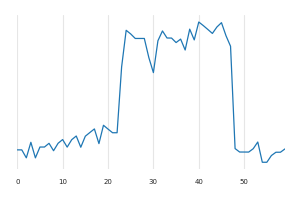
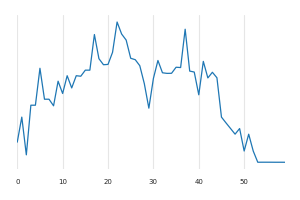
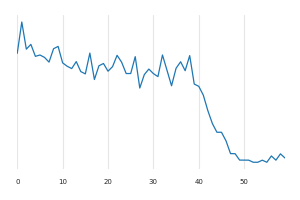
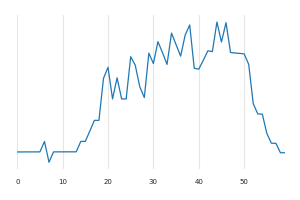
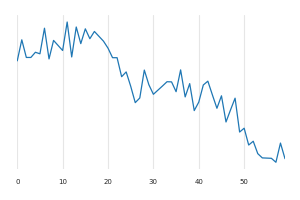
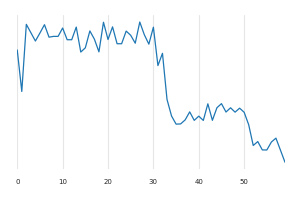
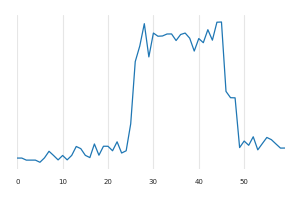
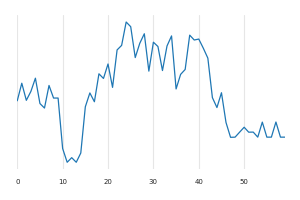
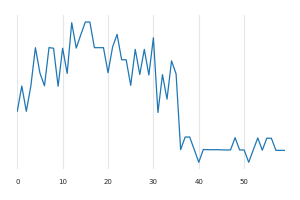
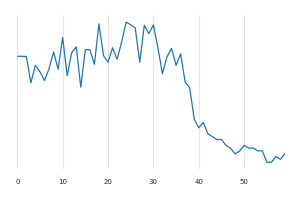

In [20]:
filtered_sparkline(opioids,
                   'practice_data_opioid/practice_data_opioidper1000',
                   'practice_data_opioidper1000')

In [21]:
practice_data_opioidspercent = practice_data_opioidspercent.replace([np.inf, -np.inf], np.nan) #replace infinite values https://stackoverflow.com/questions/17477979/dropping-infinite-values-from-dataframes-in-pandas

In [22]:
decile_highdose = pd.read_csv('data/practice_data_opioid/practice_data_opioidspercent/bq_cache.csv') ##why can't it find file if shortened url?
decile_highdose['calc_value'] = decile_highdose['numerator'] / decile_highdose['denominator']
decile_highdose['month'] = pd.to_datetime(decile_highdose['month'])
decile_highdose.head()

,month,code,numerator,denominator,calc_value
0,2018-11-01,A81001,19,61,0.311475
1,2019-08-01,A81001,13,62,0.209677
2,2014-11-01,A81001,12,57,0.210526
3,2019-07-01,A81001,13,65,0.200000
4,2017-12-01,A81001,16,59,0.271186


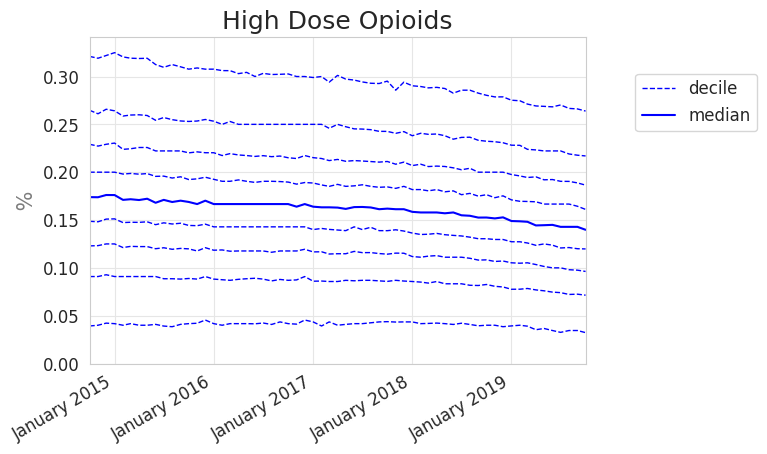

In [23]:
charts.deciles_chart(
        decile_highdose,
        period_column='month',
        column='calc_value',
        title="High Dose Opioids",
        ylabel=" % ",
        show_outer_percentiles=False,
        show_legend=True
)


plt.show()

In [24]:
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns

In [25]:
offset_date = practice_data_opioidspercent['is.tfirst.big'] -1
offset_date = offset_date.dropna().apply(lambda x: relativedelta(months=x))
practice_breaks_highdose = decile_highdose['month'].min() + offset_date
#practice_breaks_cer.loc[practice_breaks_cer=='2013-03-01'] = practice_breaks_cer.loc[practice_breaks_cer=='2013-03-01'] + pd.DateOffset(days=1)
practice_breaks_highdose.head()

name
A81001   2018-10-01
A81004   2016-05-01
A81005   2016-07-01
A81006   2017-10-01
A81007   2017-02-01
Name: is.tfirst.big, dtype: datetime64[ns]

In [26]:
mean_slope_hdose = practice_data_opioidspercent[['is.tfirst.big','is.slope.ma']]
mean_slope_hdose = mean_slope_hdose.groupby('is.tfirst.big').mean()
mean_slope_hdose = pd.concat([mean_slope_hdose,pd.DataFrame([[0]], columns=['is.slope.ma'])],axis=0)
mean_slope_hdose = mean_slope_hdose.sort_index()
mean_slope_hdose.head()#.plot.bar()

,is.slope.ma
0.0,0.000000
2.0,-0.036811
3.0,-0.044939
4.0,-0.014584
5.0,-0.027560


In [27]:
mean_change_hdose = practice_data_opioidspercent[['is.tfirst.big','is.intlev.levd']]
mean_change_hdose = mean_change_hdose.groupby('is.tfirst.big').mean()
mean_change_hdose = pd.concat([mean_change_hdose,pd.DataFrame([[0]], columns=['is.intlev.levd'])],axis=0)
mean_change_hdose = mean_change_hdose.sort_index()
mean_change_hdose.head()#.plot.bar()

,is.intlev.levd
0.0,0.000000
2.0,0.146552
3.0,0.163970
4.0,0.130250
5.0,0.115235


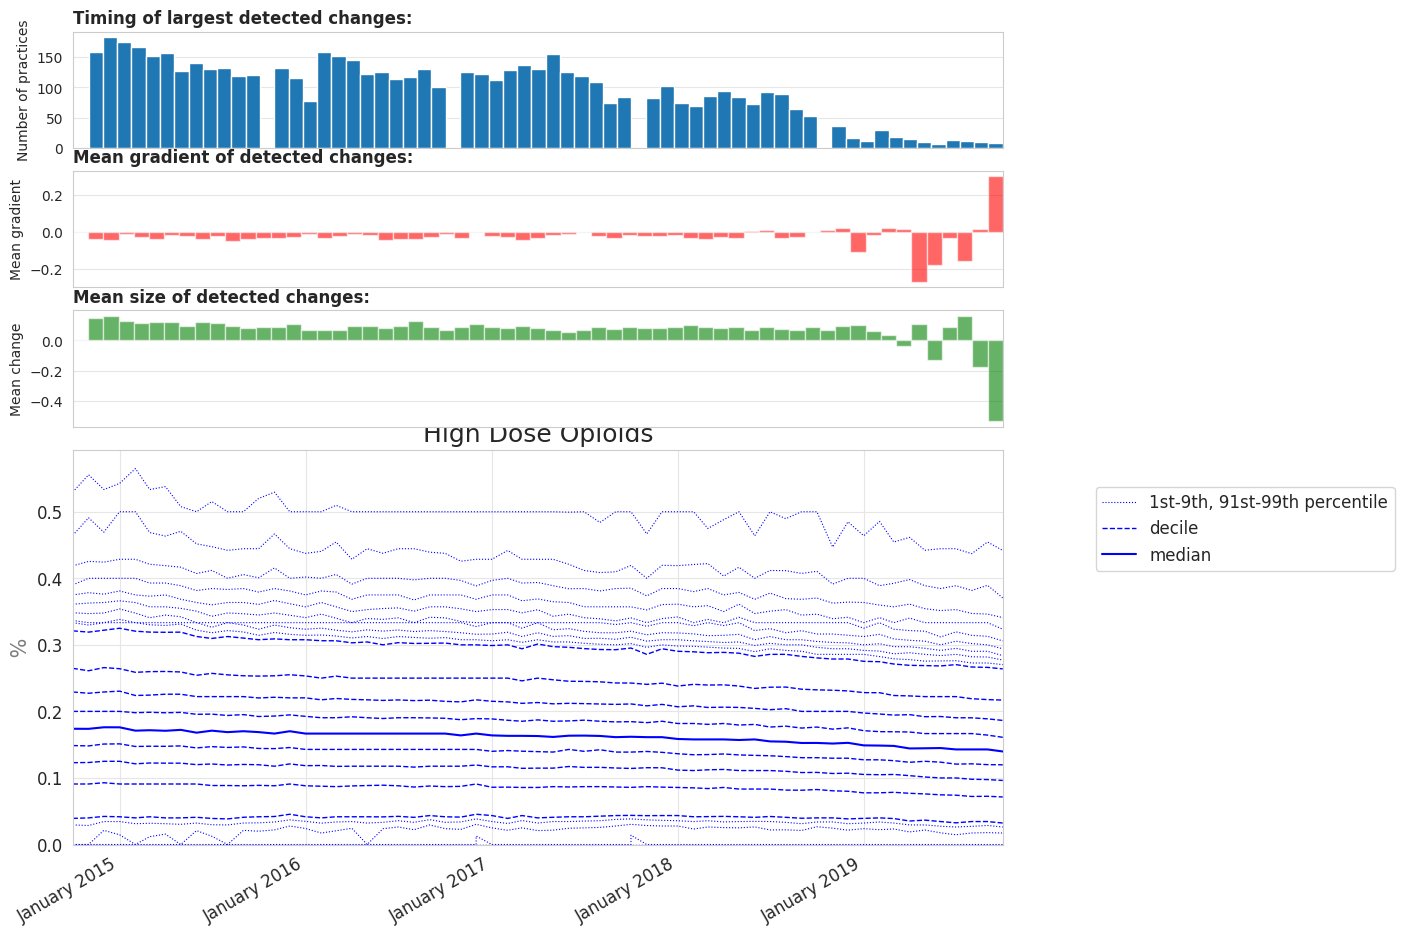

In [28]:
# Plot figure with subplots of different sizes
fig,ax = plt.subplots(1)
# set up subplot grid
gridspec.GridSpec(7,4)

# decile subplot

ax = plt.subplot2grid((7,4), (3,0), colspan=4, rowspan=3)
charts.deciles_chart(
        decile_highdose,
        period_column='month',
        column='calc_value',
        title=" High Dose Opioids ",
        ylabel=" % ",
        show_outer_percentiles=True,
        show_legend=True,
        ax=ax
)
#ax.set_title('Practice deciles and extreme percentiles:',loc='left',fontweight='bold')
#ax.set_ylabel('Proportion of Cerazette prescribing')
#ax.set_xlim([practice_deciles_cer.index.min(),practice_deciles_cer.index.max()])
#ax.set_xlabel('Year', fontsize = 11)
#ax.set_ylim([0,1])



#ax.axvline(x='2012-12-01',linewidth=1, color='k')
#ax.axvline(x='2013-07-01',linewidth=1, color='k')
#ax.annotate('Cerazette patent expired', ('2012-12-08',0.65),
 #           fontweight='bold',rotation=90,fontsize=14,color='#2a72a3',alpha=.9)
#ax.annotate('Price begins to drop', ('2013-07-08',0.53),
 #           fontweight='bold',rotation=90,fontsize=14,color='#2a72a3',alpha=.9)

# timing of change
ax = plt.subplot2grid((7,4), (0,0), colspan=4)
ax.set_title('Timing of largest detected changes:',loc='left',fontweight='bold')
ax.set_ylabel('Number of practices')
ax.axes.xaxis.set_ticklabels([])
ax.set_xlim([decile_highdose['month'].min(),decile_highdose['month'].max()])
ax.set_xticks([])
ax.hist(practice_breaks_highdose, bins=64)
#ax.axvline(x='2012-12-01',linewidth=1, color='k')
#ax.axvline(x='2013-07-01',linewidth=1, color='k')

# gradient of change
ax = plt.subplot2grid((7,4), (1,0), colspan=4)
ax.set_title('Mean gradient of detected changes:',loc='left',fontweight='bold')
ax.set_ylabel('Mean gradient')
ax.axes.xaxis.set_visible(False)
#ax.set_ylim([-0.25,0])
mean_slope_hdose.plot.bar(ax=ax, width=1, color = 'r',alpha=.6)
#ax.axvline(x=28,linewidth=1, color='k') commented out put used to put a time pint line in
#ax.axvline(x=35,linewidth=1, color='k')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend_.remove()

# magnitude of change
ax = plt.subplot2grid((7,4), (2,0), colspan=4)
ax.set_title('Mean size of detected changes:',loc='left',fontweight='bold')
ax.set_ylabel('Mean change')
ax.axes.xaxis.set_visible(False)
mean_change_hdose.plot.bar(ax=ax, width=1, color = 'g',alpha=.6)
#ax.axvline(x=28,linewidth=1, color='k')
#ax.axvline(x=35,linewidth=1, color='k')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend_.remove()

# fit subplots and save fig
fig.set_size_inches(w=12,h=14)
#fig.savefig('data/practice_data_opioid/ome.png',
#            format='png', dpi=300,bbox_inches='tight')